In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- Load and preprocess data ---
df = pd.read_csv("D:\\PROGRAMMING\\PROJECTS\\PYTHON\\TF\\RESEARCH\\RESEARCH\\DATA\\datafe.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Smooth CGM
df['CGM (mg / dl)'] = df['CGM (mg / dl)'].rolling(window=3, min_periods=1).mean()
df = df.dropna(subset=['CGM (mg / dl)'])

# --- Step 1: Derive baseline CGM using 'Dietary intake' column ---
df['baseline_CGM'] = np.nan
baseline_window = 8  # number of rows to apply baseline to after intake

for idx in df.index:
    if pd.notnull(df.loc[idx, 'Dietary intake']) and df.loc[idx, 'Dietary intake'] != 0:
        baseline_value = df.loc[idx, 'CGM (mg / dl)']
        df.loc[idx:idx + baseline_window, 'baseline_CGM'] = baseline_value

# Fill missing values forward
df['baseline_CGM'] = df['baseline_CGM'].fillna(method='ffill')
df = df.dropna(subset=['baseline_CGM'])

# Time features
df['hour'] = df['Date'].dt.hour
df['minute'] = df['Date'].dt.minute
df['dayofweek'] = df['Date'].dt.dayofweek

# --- Scaling ---
scaler_cgm = StandardScaler()
df[['CGM_scaled', 'baseline_scaled']] = scaler_cgm.fit_transform(df[['CGM (mg / dl)', 'baseline_CGM']])

scaler_time = StandardScaler()
df[['hour_scaled', 'minute_scaled', 'dayofweek_scaled']] = scaler_time.fit_transform(
    df[['hour', 'minute', 'dayofweek']]
)

# --- Prepare sequences ---
time_steps = 8
future_offsets = [1, 2, 4, 8]  # 15, 30, 60, 120 min
features = ['CGM_scaled', 'hour_scaled', 'minute_scaled', 'dayofweek_scaled', 'baseline_scaled']

X, y_15, y_30, y_60, y_120 = [], [], [], [], []

for i in range(len(df) - time_steps - max(future_offsets)):
    x_seq = df[features].iloc[i:i + time_steps].values
    X.append(x_seq)
    y_15.append(df['CGM_scaled'].iloc[i + time_steps + 0])
    y_30.append(df['CGM_scaled'].iloc[i + time_steps + 1])
    y_60.append(df['CGM_scaled'].iloc[i + time_steps + 3])
    y_120.append(df['CGM_scaled'].iloc[i + time_steps + 7])

X = np.array(X)
y_15 = np.array(y_15)
y_30 = np.array(y_30)
y_60 = np.array(y_60)
y_120 = np.array(y_120)

# --- Train-Test Split ---
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train_15, y_test_15 = y_15[:split_idx], y_15[split_idx:]
y_train_30, y_test_30 = y_30[:split_idx], y_30[split_idx:]
y_train_60, y_test_60 = y_60[:split_idx], y_60[split_idx:]
y_train_120, y_test_120 = y_120[:split_idx], y_120[split_idx:]

# --- Build & Train Model ---
def build_model():
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True), input_shape=(time_steps, X.shape[2])),
        Dropout(0.3),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(32)),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def train_model(X_train, y_train, name):
    model = build_model()
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    mc = ModelCheckpoint(f"{name}_best.keras", save_best_only=True, monitor="val_loss")
    model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, callbacks=[es, mc], verbose=1)
    return model

# Train all models
model_15 = train_model(X_train, y_train_15, "model_15")
model_30 = train_model(X_train, y_train_30, "model_30")
model_60 = train_model(X_train, y_train_60, "model_60")
model_120 = train_model(X_train, y_train_120, "model_120")


C:\Users\SANJAY\AppData\Local\Temp\ipykernel_10068\2688661971.py:14: DtypeWarning: Columns (8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("D:\\PROGRAMMING\\PROJECTS\\PYTHON\\TF\\RESEARCH\\RESEARCH\\DATA\\datafe.csv")
C:\Users\SANJAY\AppData\Local\Temp\ipykernel_10068\2688661971.py:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['baseline_CGM'] = df['baseline_CGM'].fillna(method='ffill')


Epoch 1/5


d:\PROGRAMMING\PROJECTS\PYTHON\TF\RESEARCH\.venv\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2246/2246 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - loss: 0.2964 - mae: 0.4054 - val_loss: 0.1612 - val_mae: 0.3053
Epoch 2/5
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - loss: 0.1636 - mae: 0.3002 - val_loss: 0.1459 - val_mae: 0.2870
Epoch 3/5
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - loss: 0.1392 - mae: 0.2756 - val_loss: 0.1323 - val_mae: 0.2725
Epoch 4/5
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - loss: 0.1233 - mae: 0.2578 - val_loss: 0.1381 - val_mae: 0.2750
Epoch 5/5
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - loss: 0.1148 - mae: 0.2480 - val_loss: 0.1299 - val_mae: 0.2674
Epoch 1/5
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - loss: 0.3552 - mae: 0.4411 - val_loss: 0.2443 - val_mae: 0.3738
Epoch 2/5
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - loss: 0.2120 - mae: 0.3404 - val_loss: 0.1580 - val_mae: 0.2970
Epoch 3/5
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - loss: 0.1658 - mae: 0.2982 - val_loss: 0.1547 - val_mae: 0.2908
Epoch 4/5
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 2

702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
📊 Results for 15-min
15-min - RMSE: 10.39, MAE: 7.40


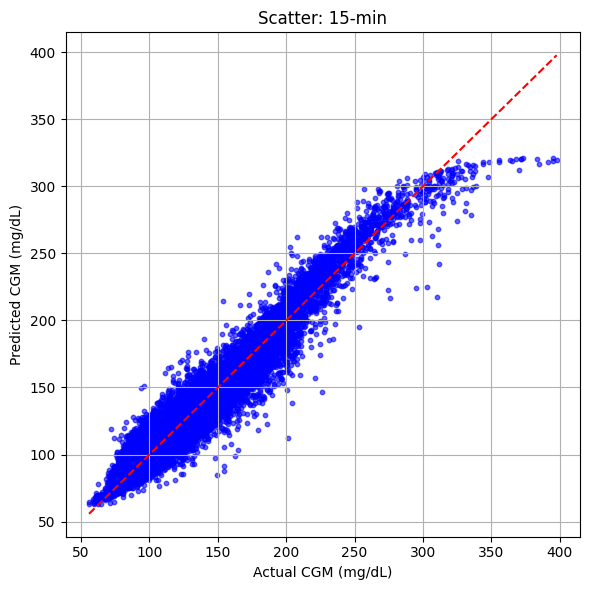

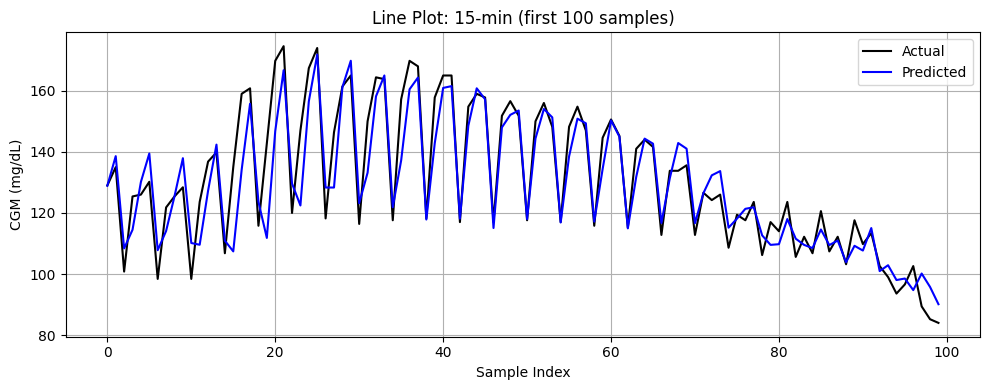

Clarke’s Error Grid Zones:
Zone A: 94.23%
Zone B: 5.76%
Zone C: 0.01%
Zone D: 0.00%
Zone E: 0.00%
📊 Results for 30-min
30-min - RMSE: 10.63, MAE: 7.28


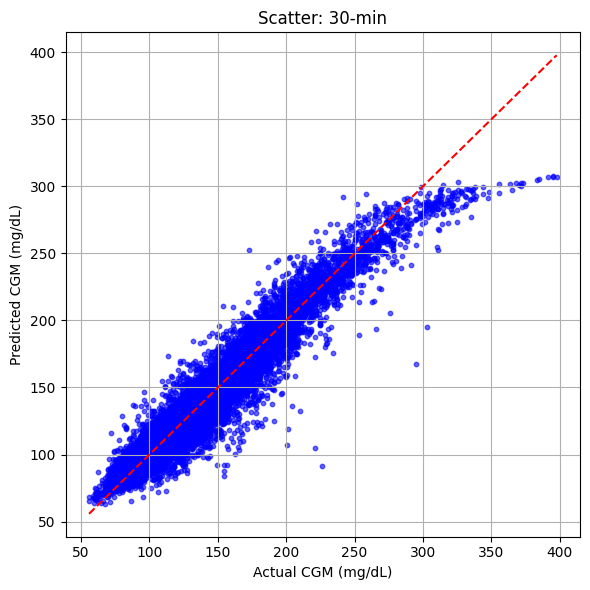

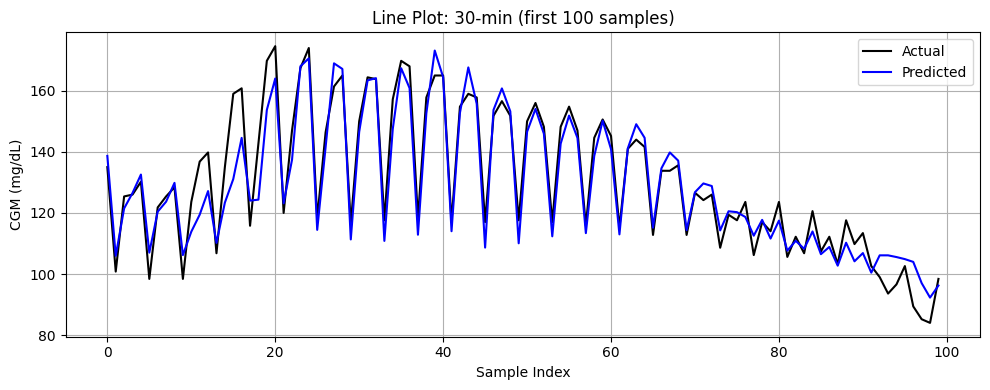

Clarke’s Error Grid Zones:
Zone A: 94.35%
Zone B: 5.60%
Zone C: 0.04%
Zone D: 0.01%
Zone E: 0.00%
📊 Results for 60-min
60-min - RMSE: 16.73, MAE: 10.81


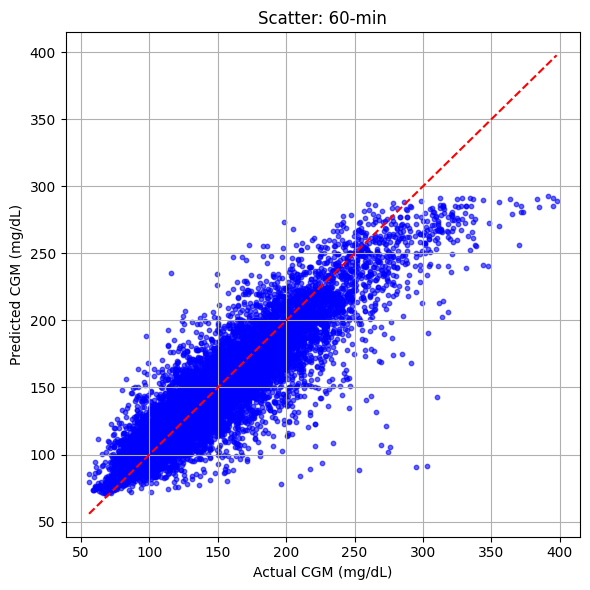

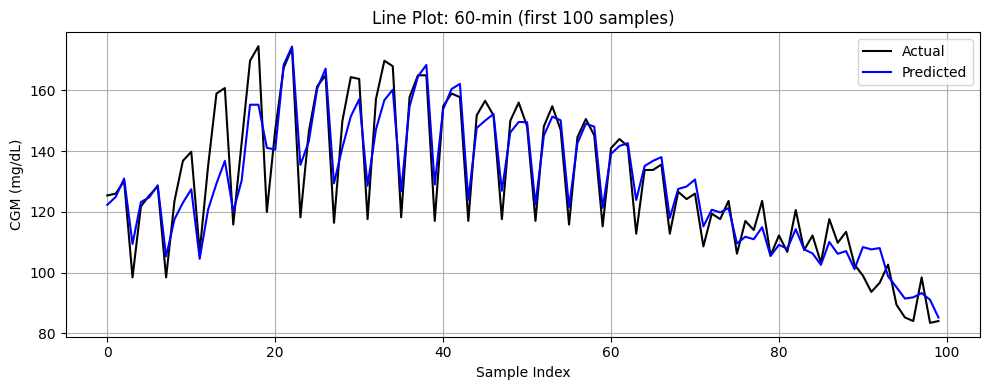

Clarke’s Error Grid Zones:
Zone A: 87.20%
Zone B: 12.59%
Zone C: 0.19%
Zone D: 0.02%
Zone E: 0.00%
📊 Results for 120-min
120-min - RMSE: 27.21, MAE: 18.31


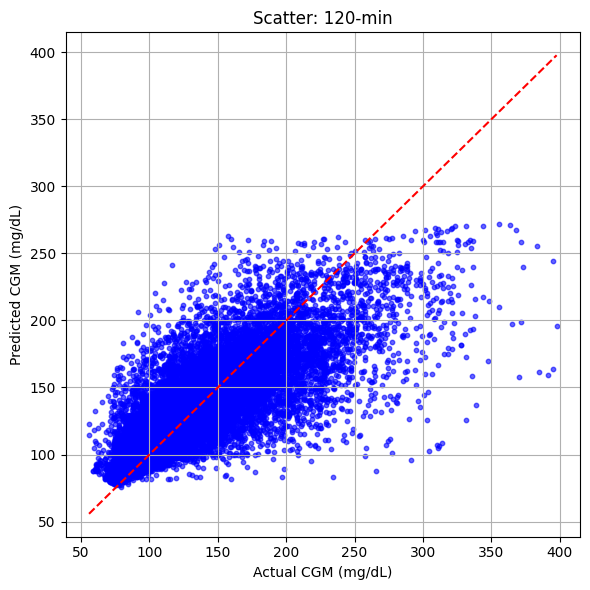

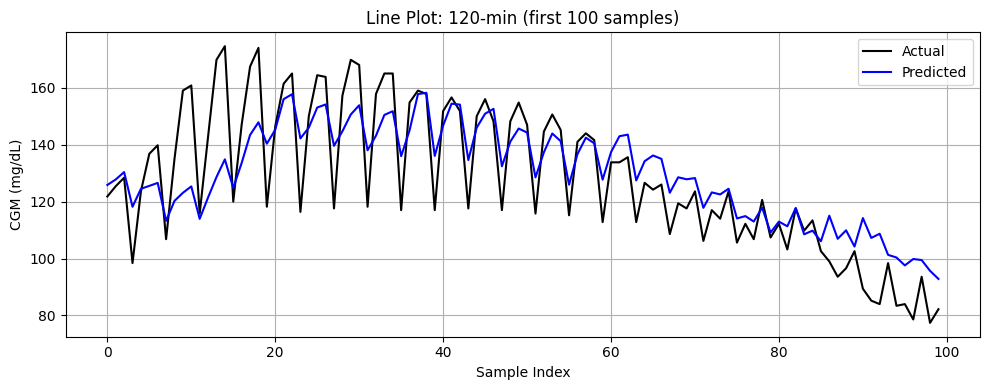

Clarke’s Error Grid Zones:
Zone A: 71.07%
Zone B: 28.12%
Zone C: 0.73%
Zone D: 0.08%
Zone E: 0.00%
📊 Results for Ensemble
Ensemble - RMSE: 12.37, MAE: 8.18


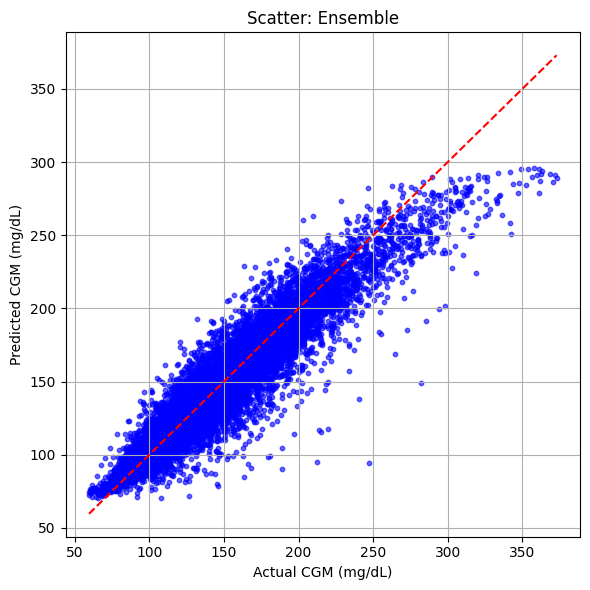

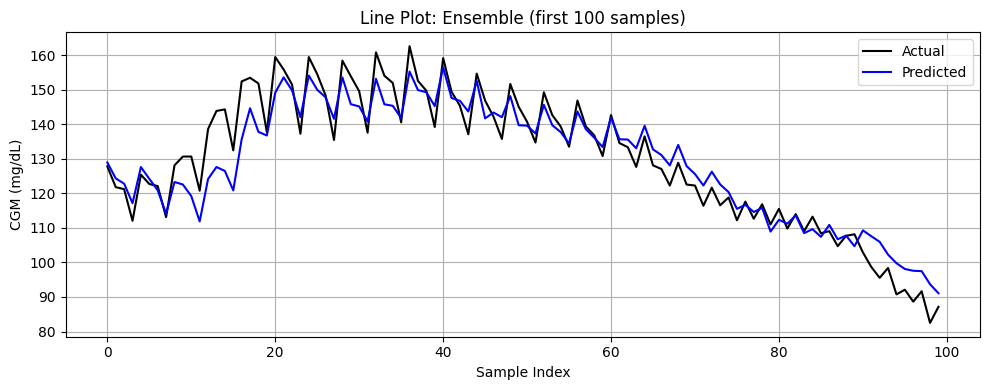

Clarke’s Error Grid Zones:
Zone A: 92.11%
Zone B: 7.83%
Zone C: 0.06%
Zone D: 0.00%
Zone E: 0.00%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Make predictions ---
y_pred_15 = model_15.predict(X_test).flatten()
y_pred_30 = model_30.predict(X_test).flatten()
y_pred_60 = model_60.predict(X_test).flatten()
y_pred_120 = model_120.predict(X_test).flatten()

# --- Inverse transform predictions and true values ---
def inverse_scale(scaler, scaled_data, col_index):
    dummy = np.zeros((len(scaled_data), scaler.mean_.shape[0]))
    dummy[:, col_index] = scaled_data
    return scaler.inverse_transform(dummy)[:, col_index]

# Inverse scaled true values
y_true_15_inv = inverse_scale(scaler_cgm, y_test_15, 0)
y_true_30_inv = inverse_scale(scaler_cgm, y_test_30, 0)
y_true_60_inv = inverse_scale(scaler_cgm, y_test_60, 0)
y_true_120_inv = inverse_scale(scaler_cgm, y_test_120, 0)

# Inverse scaled predicted values
y_pred_15_inv = inverse_scale(scaler_cgm, y_pred_15, 0)
y_pred_30_inv = inverse_scale(scaler_cgm, y_pred_30, 0)
y_pred_60_inv = inverse_scale(scaler_cgm, y_pred_60, 0)
y_pred_120_inv = inverse_scale(scaler_cgm, y_pred_120, 0)

# --- Ensemble prediction ---
y_true_ensemble = (y_true_15_inv + y_true_30_inv + y_true_60_inv + y_true_120_inv) / 4
y_pred_ensemble = (y_pred_15_inv + y_pred_30_inv + y_pred_60_inv + y_pred_120_inv) / 4

# --- Evaluation Function ---
def evaluate(true, pred, label):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    print(f"{label} - RMSE: {rmse:.2f}, MAE: {mae:.2f}")
    return rmse, mae

# --- Scatter Plot ---
def plot_scatter(true, pred, title):
    plt.figure(figsize=(6, 6))
    plt.scatter(true, pred, alpha=0.6, color="blue", s=10)
    plt.plot([min(true), max(true)], [min(true), max(true)], 'r--')
    plt.xlabel("Actual CGM (mg/dL)")
    plt.ylabel("Predicted CGM (mg/dL)")
    plt.title(f"Scatter: {title}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Line Plot ---
def plot_line(true, pred, title, n=100):
    plt.figure(figsize=(10, 4))
    plt.plot(true[:n], label="Actual", color='black')
    plt.plot(pred[:n], label="Predicted", color='blue')
    plt.title(f"Line Plot: {title} (first {n} samples)")
    plt.xlabel("Sample Index")
    plt.ylabel("CGM (mg/dL)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Clarke’s Error Grid ---
def clarke_error_grid(true, pred):
    A = B = C = D = E = 0
    for t, p in zip(true, pred):
        if t <= 70:
            if p <= 70:
                A += 1
            elif p <= 180:
                B += 1
            else:
                E += 1
        elif t <= 180:
            if abs(t - p) <= 20:
                A += 1
            elif p <= 70 or p > 240:
                D += 1
            else:
                B += 1
        else:
            if p > 180:
                A += 1
            elif p > 130:
                B += 1
            elif p > 70:
                C += 1
            else:
                E += 1
    total = len(true)
    print(f"Clarke’s Error Grid Zones:")
    print(f"Zone A: {A / total * 100:.2f}%")
    print(f"Zone B: {B / total * 100:.2f}%")
    print(f"Zone C: {C / total * 100:.2f}%")
    print(f"Zone D: {D / total * 100:.2f}%")
    print(f"Zone E: {E / total * 100:.2f}%")

# --- Run all evaluations and plots ---
intervals = [
    ("15-min", y_true_15_inv, y_pred_15_inv),
    ("30-min", y_true_30_inv, y_pred_30_inv),
    ("60-min", y_true_60_inv, y_pred_60_inv),
    ("120-min", y_true_120_inv, y_pred_120_inv),
    ("Ensemble", y_true_ensemble, y_pred_ensemble),
]

for label, y_true, y_pred in intervals:
    print("=" * 60)
    print(f"📊 Results for {label}")
    evaluate(y_true, y_pred, label)
    plot_scatter(y_true, y_pred, title=label)
    plot_line(y_true, y_pred, title=label)
    clarke_error_grid(y_true, y_pred)